In [1]:
# originally from 
# https://github.com/COSIMA/ACCESS-OM2-1-025-010deg-report/blob/master/figures/bathymetry/bathymetry.ipynb
%matplotlib inline

# import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
# from matplotlib import cm
# from mpl_toolkits.basemap import Basemap # plot on map projections
# import netCDF4 as nc
# import IPython.display
# import cmocean
from glob import glob
import os
# import sys
# import yaml
# import math
import xarray as xr
# import copy
from collections import OrderedDict

# sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
# import exptdata
# print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
data = dict()

In [3]:
data['previous 1deg topo'] = \
              {'desc': 'previous 1deg topo',
#                'exptdir': '/g/data/ik11/outputs/access-om2-01/1deg_jra55v140_iaf',
               'mominput': '/g/data/ik11/inputs/access-om2/input_20200530/mom_1deg',
#                'st_edges_ocean_file': 'ocean/ocean-3d-temp-1-monthly-mean-ym_????_??.nc',
               'kmt_file': 'ocean/ocean-2d-kmt.nc',
               'topog_file': 'topog.nc'
              }

In [4]:
data['new 1deg topo'] = \
              {'desc': 'new 1deg topo',
#                'exptdir': '/g/data/ik11/outputs/access-om2-01/01deg_jra55v140_iaf',
               'mominput': '/scratch/v45/aek156/bathymetry/tools/1_deg_test',
#                'st_edges_ocean_file': 'ocean/ocean-3d-temp-1-monthly-mean-ym_????_??.nc',
               'kmt_file': 'ocean/ocean-2d-kmt.nc',
               'topog_file': 'topog_new_deseas_partialcell_mindepth_masked_fixnonadvective.nc'
              }

In [5]:
data['previous 025deg topo'] = \
              {'desc': 'previous 025deg topo',
#                'exptdir': '/g/data/ik11/outputs/access-om2-01/1deg_jra55v140_iaf',
               'mominput': '/g/data/ik11/inputs/access-om2/input_20200530/mom_025deg',
#                'st_edges_ocean_file': 'ocean/ocean-3d-temp-1-monthly-mean-ym_????_??.nc',
               'kmt_file': 'ocean/ocean-2d-kmt.nc',
               'topog_file': 'topog.nc'
              }

In [6]:
data['new 0.25deg topo'] = \
              {'desc': 'new 0.25deg topo',
#                'exptdir': '/g/data/ik11/outputs/access-om2-01/01deg_jra55v140_iaf',
               'mominput': '/scratch/v45/aek156/bathymetry/tools/025_deg_test',
#                'st_edges_ocean_file': 'ocean/ocean-3d-temp-1-monthly-mean-ym_????_??.nc',
               'kmt_file': 'ocean/ocean-2d-kmt.nc',
               'topog_file': 'topog_new_deseas_partialcell_mindepth_masked_fixnonadvective.nc'
              }

In [7]:
def calc_kmt(ht, zw, min_thickness):
# calculate kmt based on this MOM code from
# https://github.com/mom-ocean/MOM5/blob/145ef5ca798da9a809393002efd8901933908164/src/mom5/ocean_core/ocean_topog.F90#L213-L227
#      do j=jsc,jec
#         do i=isc,iec
#            if(Grid%ht(i,j) <= 0.0) then
#               Grid%kmt(i,j) = 0
#            else
#               Grid%kmt(i,j) = nearest_index(Grid%ht(i,j), Grid%zw)
#               if( Grid%ht(i,j) >= Grid%zw(Grid%kmt(i,j)) + min_thickness) then 
#                  if(Grid%kmt(i,j) < nk) then
#                     Grid%kmt(i,j) = Grid%kmt(i,j) + 1
#                  endif
#               endif
#            endif
#         enddo
#      enddo
    kmt = xr.full_like(ht, 0)
    for k,z in enumerate(zw.data):
        kmt = kmt.where(ht<z+min_thickness).fillna(k+1)
    kmt = kmt.where(kmt<k+1)
    return kmt

In [8]:
for ekey, e in data.items():
    e['depth'] = xr.open_dataset(os.path.join(e['mominput'],e['topog_file'])).depth  # partial depth
    if False:
# load things from final output dir in exptdir
        outdirs = glob(os.path.join(e['exptdir'], 'output*'))
        outdirs.sort()
        st_edges_ocean_files = glob(os.path.join(outdirs[-1], e['st_edges_ocean_file']))
        e['st_edges_ocean'] = xr.open_dataset(st_edges_ocean_files[-1]).st_edges_ocean#.values
        kmt_files = glob(os.path.join(outdirs[-1], e['kmt_file']))
        e['kmt'] = xr.open_dataset(kmt_files[-1]).kmt #.values
    else:
# load things from mominput
        e['st_edges_ocean']= xr.open_dataset(os.path.join(e['mominput'],'ocean_vgrid.nc')).zeta[0::2].rename(nzv='st_edges_ocean')
        e['kmt'] = calc_kmt(e['depth'], e['st_edges_ocean'], 0.001)
    e['calc_kmt'] = calc_kmt(e['depth'], e['st_edges_ocean'], 0.001)
    e['lat']= xr.open_dataset(os.path.join(e['mominput'],'ocean_hgrid.nc')).y[0::2,0::2].rename(nxp='nx', nyp='ny')
    e['lon']= xr.open_dataset(os.path.join(e['mominput'],'ocean_hgrid.nc')).x[0::2,0::2].rename(nxp='nx', nyp='ny')

# calculate things
    kmt_idx = e['kmt'].astype(np.int64).clip(min=0)
    tmp = e['st_edges_ocean'][kmt_idx]  # full depth, land is zero
    e['depth_full'] = tmp.where(tmp > 0)  # full depth, land is nan
    dzfull = e['st_edges_ocean'].diff('st_edges_ocean')
#     dzfull = e['st_edges_ocean'].diff('nzv')
#     print(dzfull)
    dzftmp = dzfull[e['kmt'].astype(np.int64).clip(min=1)-1]  # full depth dz, land is wrong
    e['dz_full'] = dzftmp.where(tmp > 0)  # full depth dz, land is nan
    dztmp = e['depth'].values - e['st_edges_ocean'][(kmt_idx-1).clip(min=0)]  # partial depth dz, land is wrong
    e['dz'] = dztmp.where(tmp > 0)  # partial depth dz, land is nan

## Check min and max thickness

In [9]:
for ekey, e in data.items():
    print(ekey, e['desc'])
    print('min levels =', int(e['kmt'].min().item(0)))
    print('min partial cell depth   =', e['depth'].where(e['depth']>0).min().item(0),'m')
#     print('min full cell depth =', e['st_edges_ocean'][int(e['kmt'].min().item(0))].item(0),'m')
    print('min full cell depth =', e['depth_full'].min().item(0),'m')
    print('max full cell depth =', e['depth_full'].max().item(0),'m')
    print('min partial cell thickness at bottom =', e['dz'].min().item(0),'m')
    print('min full cell thickness at bottom =', e['dz_full'].min().item(0),'m')
    ratio = e['dz']/e['dz_full']
    print('min partial/full thickness at bottom =', ratio.min().item(0))
    print('max partial/full thickness at bottom =', ratio.max().item(0))
    print('number of cells with partial > full thickness at bottom =', ratio.where(ratio>1).count().item(0))
    print('min partial-full thickness at bottom, where partial>full =', (e['dz']-e['dz_full']).where(e['dz']>e['dz_full']+1e-5).min().item(0))
    print('max partial-full thickness at bottom =', (e['dz']-e['dz_full']).max().item(0))

    print()

previous 1deg topo previous 1deg topo
min levels = 0
min partial cell depth   = 45.111485611302065 m
min full cell depth = 51.04873935697576 m
max full cell depth = 5363.469120676253 m
min partial cell thickness at bottom = 2.9616320801266482 m
min full cell thickness at bottom = 9.308074817051192 m
min partial/full thickness at bottom = 0.20000000298023027
max partial/full thickness at bottom = 1.0
number of cells with partial > full thickness at bottom = 0
min partial-full thickness at bottom, where partial>full = nan
max partial-full thickness at bottom = 0.0

new 1deg topo new 1deg topo
min levels = 4
min partial cell depth   = 11.805749893188477 m
min full cell depth = 11.805749893188477 m
max full cell depth = 5363.46923828125 m
min partial cell thickness at bottom = 1.0 m
min full cell thickness at bottom = 3.6697616577148438 m
min partial/full thickness at bottom = 0.19999951347196138
max partial/full thickness at bottom = 1.0
number of cells with partial > full thickness at bo

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/xarray/core/nputils.py:220: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwds)


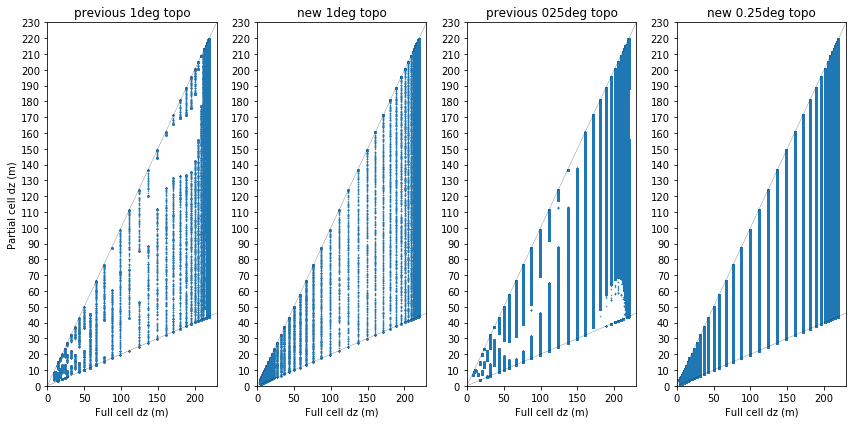

In [10]:
plt.figure(figsize=(12,6))
for i, ekey in enumerate(data.keys()):
    e = data[ekey]
    plt.subplot(1,len(data.keys()),i+1)
    plt.plot([0, 230],[0,230],'k',linewidth=0.2)
    plt.plot([0, 230],[0,230*0.2],'k',linewidth=0.2)
    plt.scatter(e['dz_full'], e['dz'], s=0.2)
    plt.xlim(0,230)
    plt.ylim(0,230)
    plt.yticks(np.arange(0, 231, step=10))
    plt.xlabel('Full cell dz (m)')
    plt.title(e['desc'])
    if i == 0:
        plt.ylabel('Partial cell dz (m)')
#     else:
#         plt.gca().axes.yaxis.set_ticklabels([])
#     plt.axes().set_aspect('equal')
plt.tight_layout()
# savefigure(fileprefix+'partialcells.png')

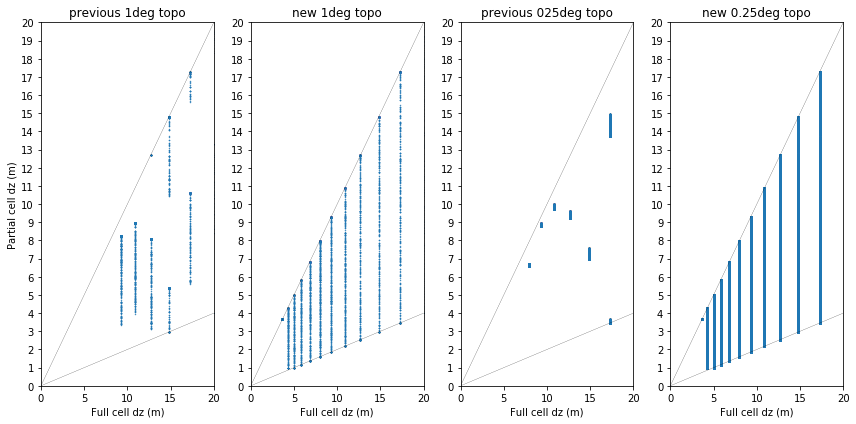

In [11]:
plt.figure(figsize=(12,6))
for i, ekey in enumerate(data.keys()):
    e = data[ekey]
    plt.subplot(1,len(data.keys()),i+1)
    plt.plot([0, 20],[0,20],'k',linewidth=0.2)
    plt.plot([0, 20],[0,20*0.2],'k',linewidth=0.2)
    plt.scatter(e['dz_full'], e['dz'], s=0.2)
    plt.xlim(0,20)
    plt.ylim(0,20)
    plt.yticks(np.arange(0, 21, step=1))
    plt.xlabel('Full cell dz (m)')
    plt.title(e['desc'])
    if i == 0:
        plt.ylabel('Partial cell dz (m)')
#     else:
#         plt.gca().axes.yaxis.set_ticklabels([])
#     plt.axes().set_aspect('equal')
plt.tight_layout()
# savefigure(fileprefix+'partialcells_closeup.png')

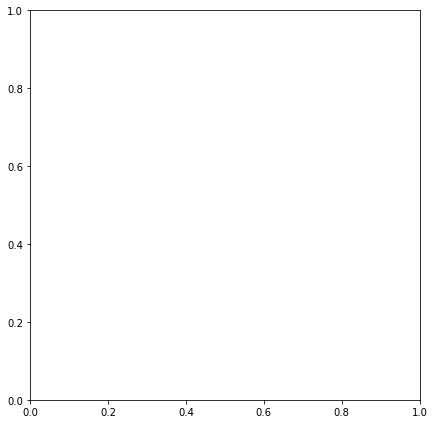

In [12]:
# check calc_kmt
plt.figure(figsize=(12,6))
for i, ekey in enumerate(data.keys()):
    e = data[ekey]
    plt.subplot(1,len(data.keys()),i+1)
    plt.scatter(e['kmt'], e['calc_kmt'], s=0.2)
    plt.plot([0, 80],[0,80],'r',linewidth=0.2)
    plt.xlim(0,80)
    plt.ylim(0,80)
    plt.xlabel('kmt')
    plt.ylabel('calc_kmt')
    plt.title(e['desc'])
    plt.axes().set_aspect('equal')
plt.tight_layout()
# savefigure(fileprefix+'partialcells.png')

[0.]
[ 0. nan nan ... nan nan nan]
[0.]
[ 0. nan nan ... nan nan nan]


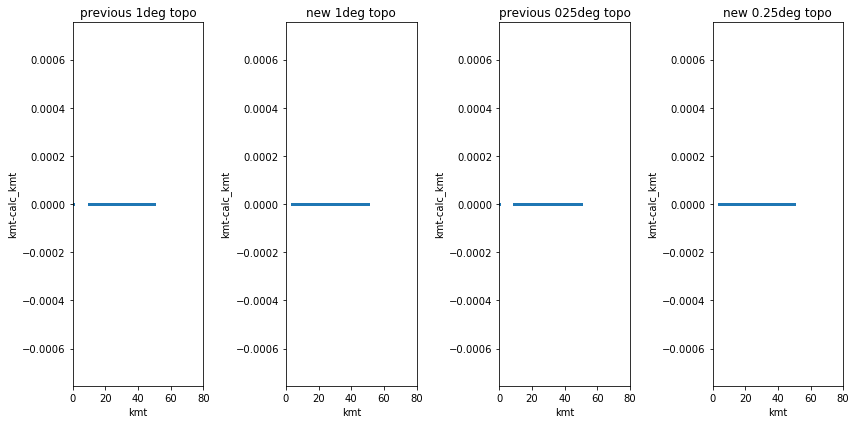

In [13]:
plt.figure(figsize=(12,6))
for i, ekey in enumerate(data.keys()):
    e = data[ekey]
    plt.subplot(1,len(data.keys()),i+1)
    plt.scatter(e['kmt'], e['kmt'].data-e['calc_kmt'].data, s=0.2)
#     plt.plot([0, 80],[0,80],'r',linewidth=0.2)
    plt.xlim(0,80)
#     plt.ylim(0,80)
    plt.xlabel('kmt')
    plt.ylabel('kmt-calc_kmt')
    plt.title(e['desc'])
#     plt.axes().set_aspect('equal')
    print(np.unique(e['kmt'].data-e['calc_kmt'].data))
plt.tight_layout()
# savefigure(fileprefix+'partialcells.png')

## View topog files

/g/data/ik11/inputs/access-om2/input_20200530/mom_1deg/topog.nc
<xarray.DataArray 'depth' ()>
array(0.)
<xarray.DataArray 'depth' ()>
array(45.111486)
<xarray.DataArray 'depth' ()>
array(5363.469121)

/scratch/v45/aek156/bathymetry/tools/1_deg_test/topog.nc
<xarray.DataArray 'depth' ()>
array(0.)
<xarray.DataArray 'depth' ()>
array(45.111486)
<xarray.DataArray 'depth' ()>
array(5363.469121)

/scratch/v45/aek156/bathymetry/tools/1_deg_test/topog_new.nc
<xarray.DataArray 'depth' ()>
array(0., dtype=float32)
<xarray.DataArray 'depth' ()>
array(1., dtype=float32)
<xarray.DataArray 'depth' ()>
array(8514.992, dtype=float32)

/scratch/v45/aek156/bathymetry/tools/1_deg_test/topog_new_deseas.nc
<xarray.DataArray 'depth' ()>
array(1., dtype=float32)
<xarray.DataArray 'depth' ()>
array(1., dtype=float32)
<xarray.DataArray 'depth' ()>
array(8514.992, dtype=float32)

/scratch/v45/aek156/bathymetry/tools/1_deg_test/topog_new_deseas_partialcell.nc
<xarray.DataArray 'depth' ()>
array(2.3035, dtype=fl

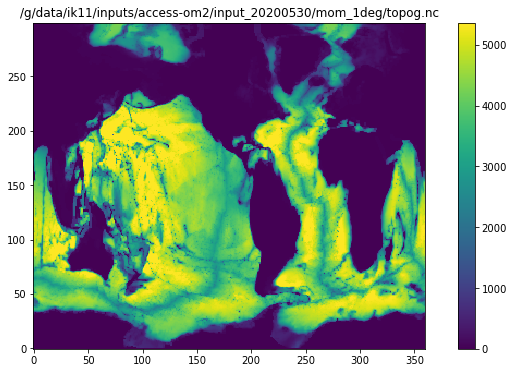

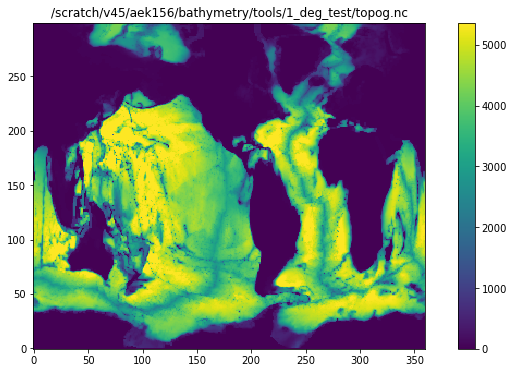

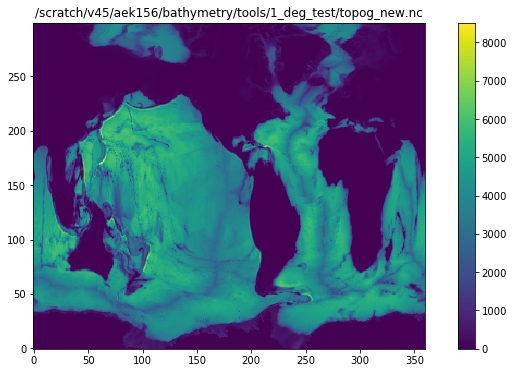

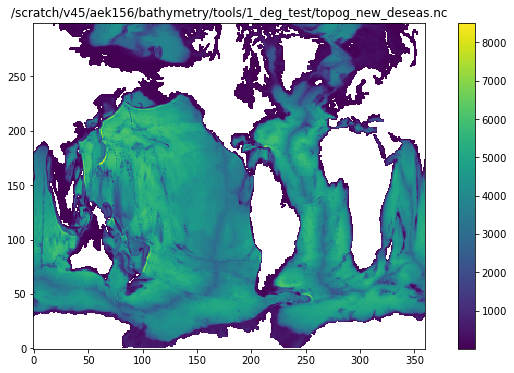

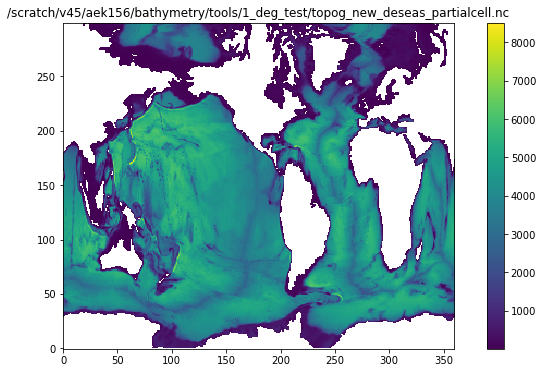

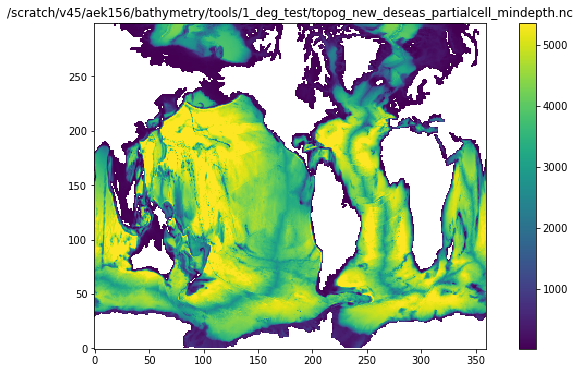

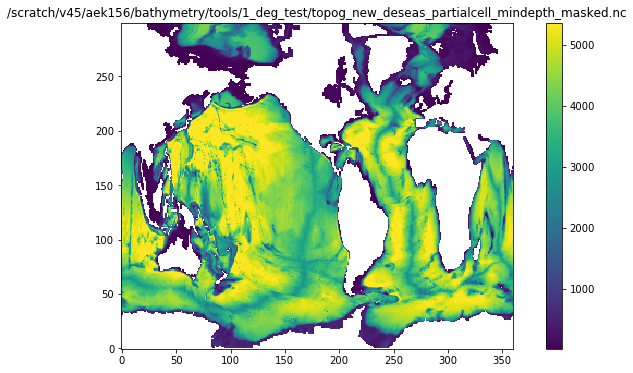

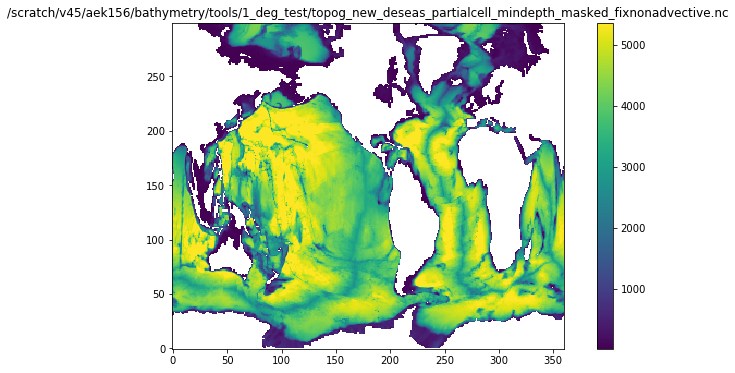

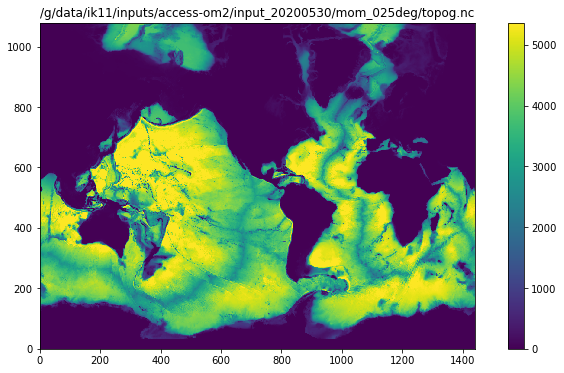

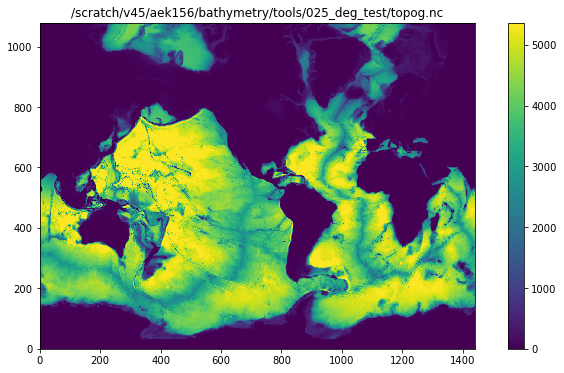

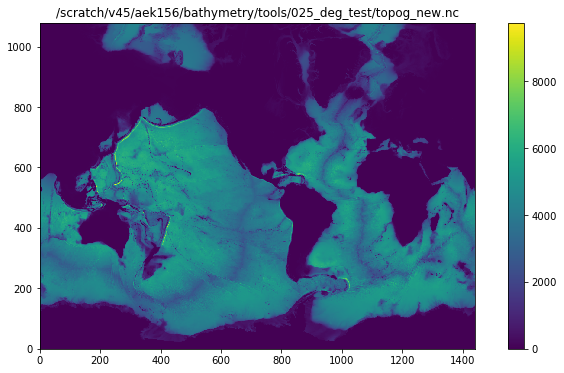

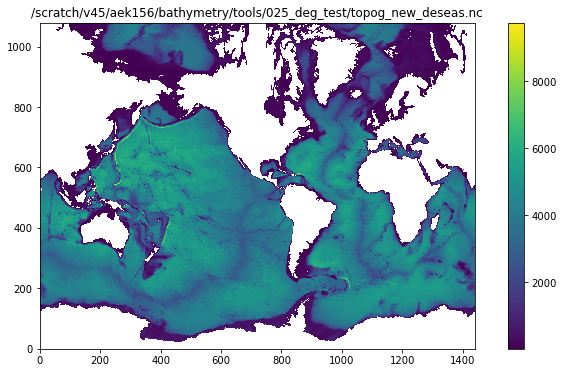

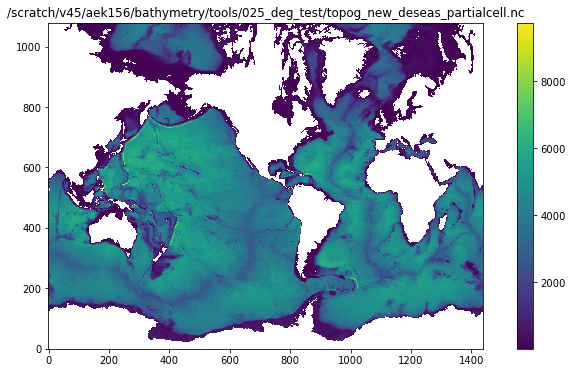

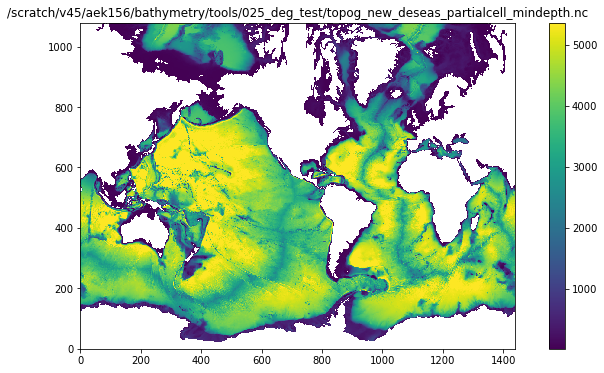

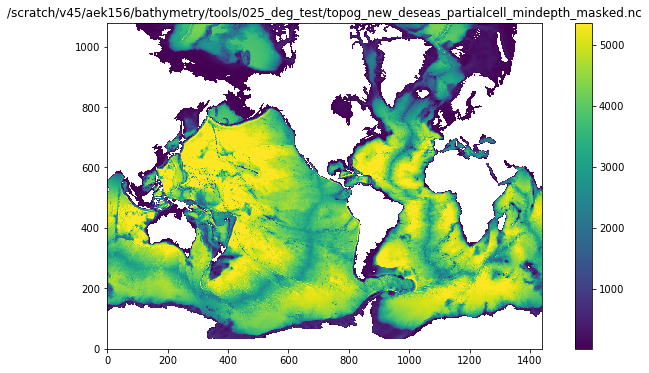

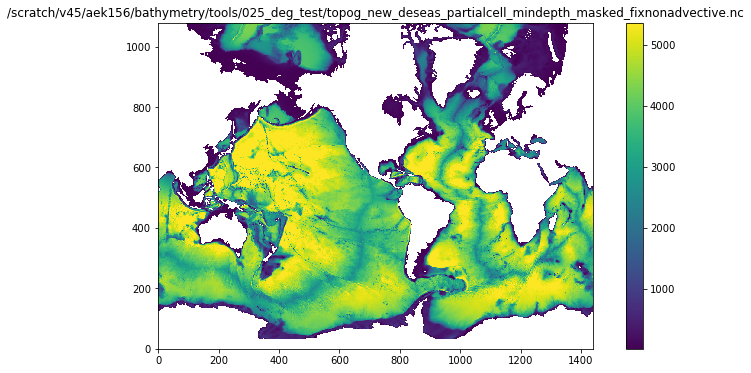

In [14]:
for ekey, e in data.items():
    topofiles = glob(os.path.join(e['mominput'], 'topog*.nc'))
    topofiles.sort()
    for f in topofiles:
        print(f)
        d = xr.open_dataset(os.path.join(e['mominput'],f)).depth
        minimum_depth = d.where(d>0.0).min()
#         print(d)
        print(d.min())
        print(d.where(d>0.0).min())
        print(d.max())
        print()
        plt.figure(figsize=(12,6))
        plt.imshow(d.data)
        plt.gca().invert_yaxis()
        plt.colorbar()
        plt.title(f)

## Show topog file changes

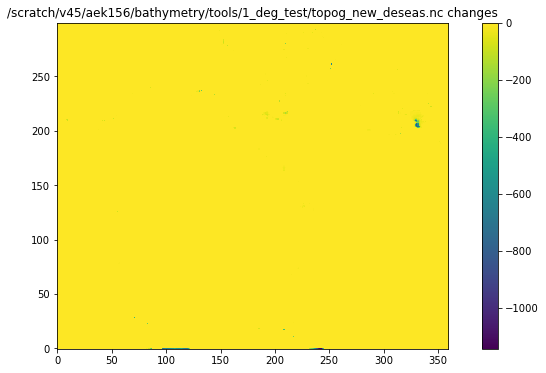

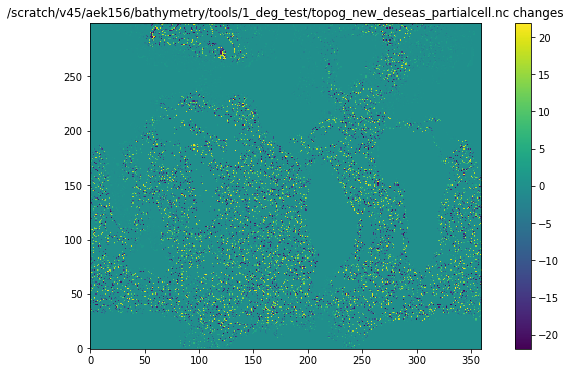

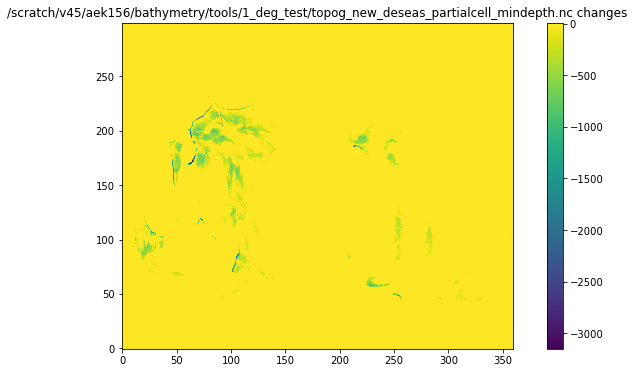

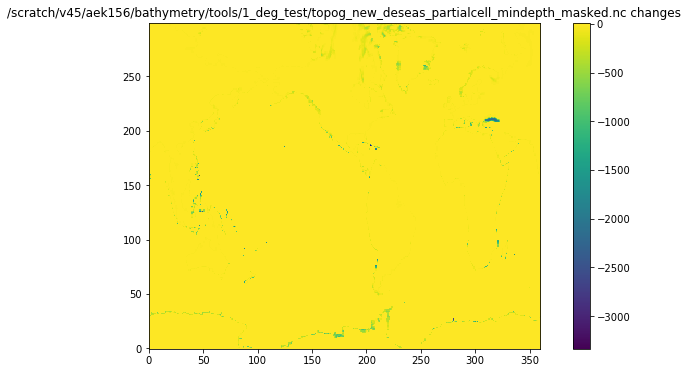

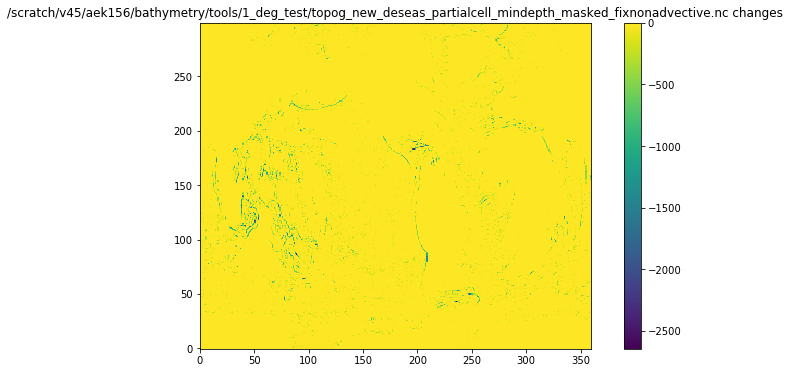

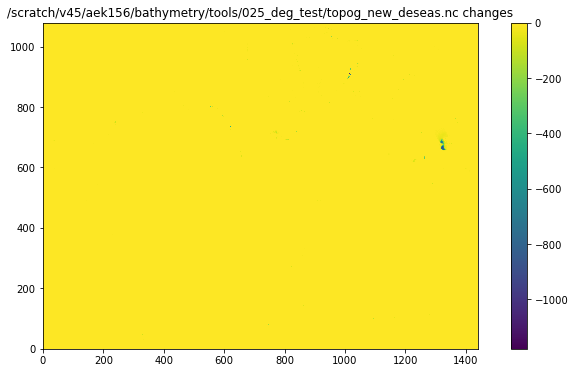

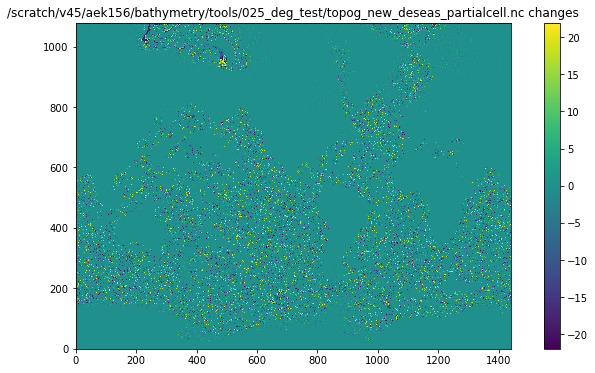

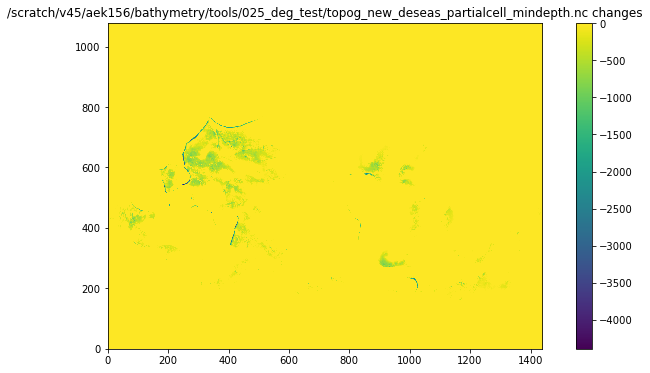

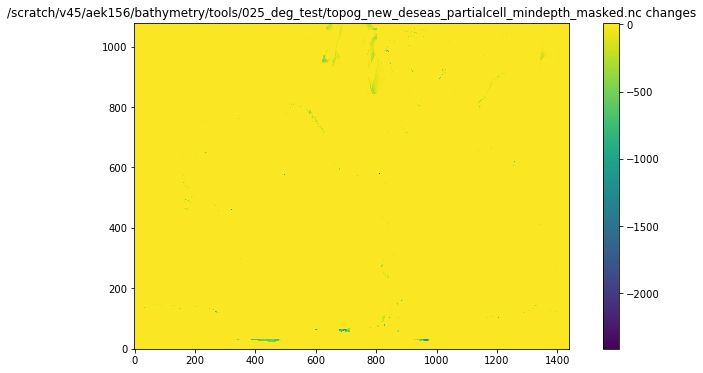

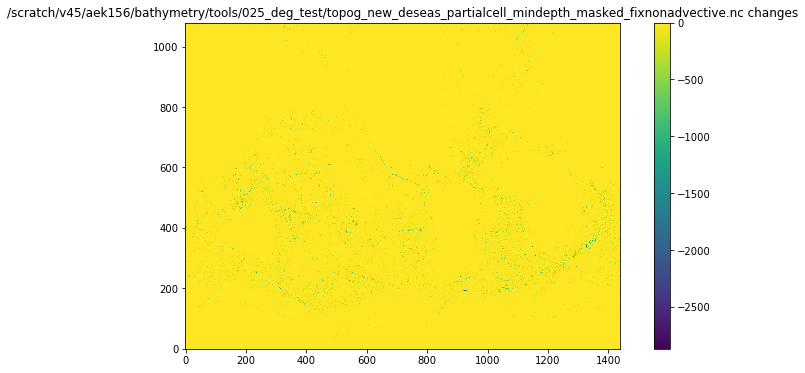

In [15]:
for ekey, e in data.items():
    topofiles = glob(os.path.join(e['mominput'], 'topog_new*.nc'))
    topofiles.sort()
    if len(topofiles):
        d = xr.open_dataset(os.path.join(e['mominput'],topofiles[0])).depth.fillna(0.0)
        for f in topofiles[1:]:
            prev = d
            d = xr.open_dataset(os.path.join(e['mominput'],f)).depth.fillna(0.0)
            plt.figure(figsize=(12,6))
            plt.imshow(d.data - prev.data)
            plt.gca().invert_yaxis()
            plt.colorbar()
            plt.title(f+' changes')

## Check specific features (straits, seamounts, etc)

In [16]:
# see https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates
# this is a dumb, slow method but it works.
# a k-d tree would be faster per query but takes some setup time
def nearest(lons, lats, lon, lat):
    # return (i,j) index into lons, lats arrays which most closely matches lon, lat
    londiff = np.abs(lons-lon)
    latdiff = np.abs(lats-lat)
    c = np.maximum(londiff, latdiff)
    (j, i) = np.where(c == np.min(c))
    return i[0],j[0]

In [25]:
# ('label', [lonmin, lonmax, latmin, latmax])
features = OrderedDict([ # use OrderedDict so panels are produced in a reproducible order
            ('Drake Passage', [-75, -50, -71.6, -51.0]),
            ('Lombok Strait', [-245.3, -242.8, -9.37, -7.37]),
            ('Ombai Strait',  [-235.9, -233.9, -9.86, -7.27]),
            ('Timor Strait',  [-236, -230.6, -13.96, -8.37]),
            ('Bering Strait', [-172, -167, 65.8, 65.8]),
            ('Denmark Strait',[-42, -22, 62, 69]),
            ('Iceland-Faroe Strait',[-24, 0, 58, 68]), # https://os.copernicus.org/articles/14/871/2018/
#             ('East Taiwan Channel',[120.7-360, 124-360, 23.4, 25.4]),  # WOCE PCM-1 array between Taiwan and Iriomote (JohnsLeeZhangZantoppLiuYang2001a)
            ('Florida Current',[-81, -77.8, 24.7, 26.7]),  # MeinenBaringerGarcia2010a
            ('Macquarie Island',[156-360, 162-360, -58, -51]),
            ('Tasman seamounts',[150-360, 165-360, -42, -20]),
            ('Fram Strait', [-25, 25, 77, 85]),
            ('Strait of Gibraltar', [-7, -2, 34, 37]),
#  places with dodgy topo in old files
            ('Gulf of Carpentaria', [135-360, 142-360, -18, -8]),
            ('Bass Strait', [145-360, 147-360, -40, -38]),
            ('Laptev Sea', [110-360, 170-360, 71, 77]),
            ('Chukchi Sea', [-190, -160, 60, 77]),
            ('White Sea', [30, 50, 62, 70]),
            ('Alaskan coast', [180-360, 210-360, 50, 65]),
            ('Yellow Sea', [115-360, 130-360, 25, 40]),
            ('East China sea near Taiwan', [110-360, 130-360, 20, 30]),
            ('Between Hainan and Vietnam', [107-360, 110-360, 17, 22]),
            ])


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous a

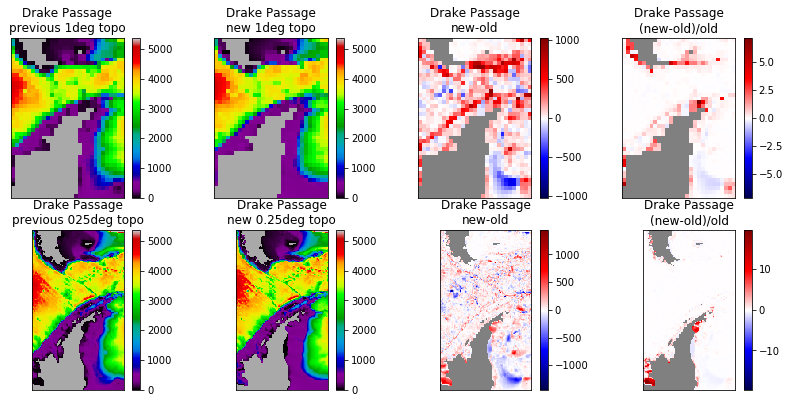

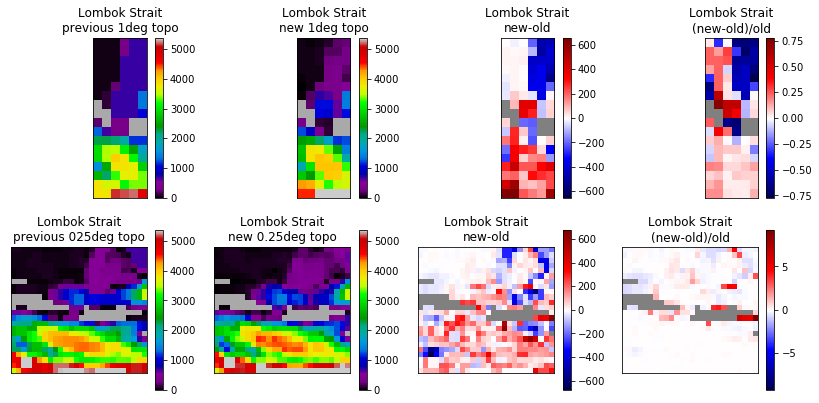

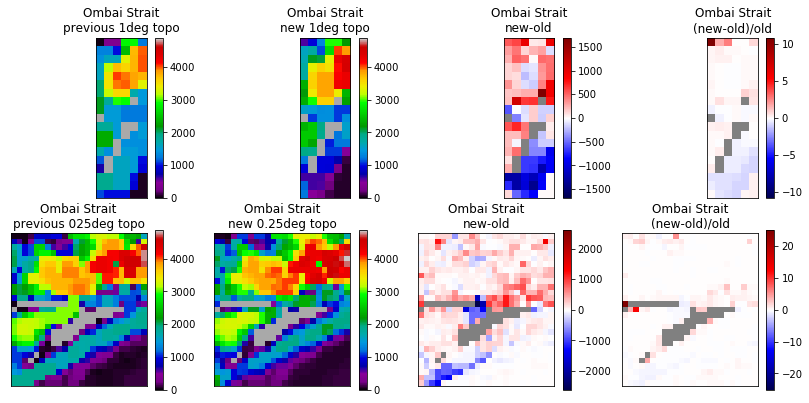

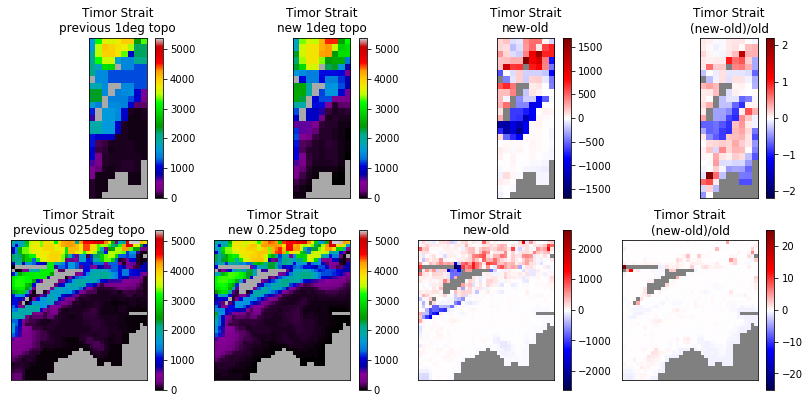

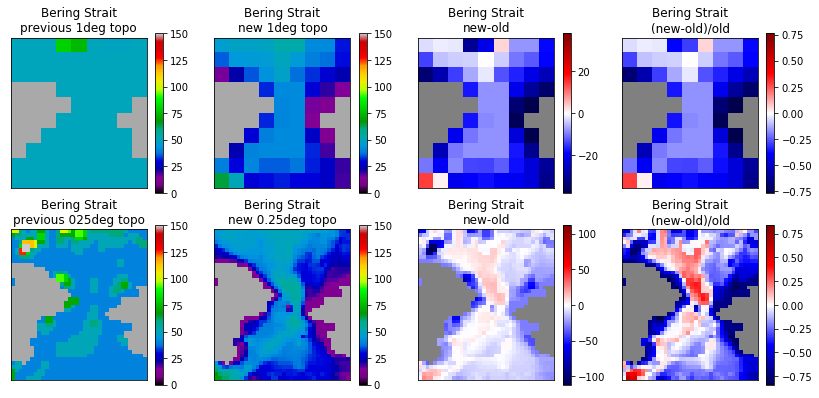

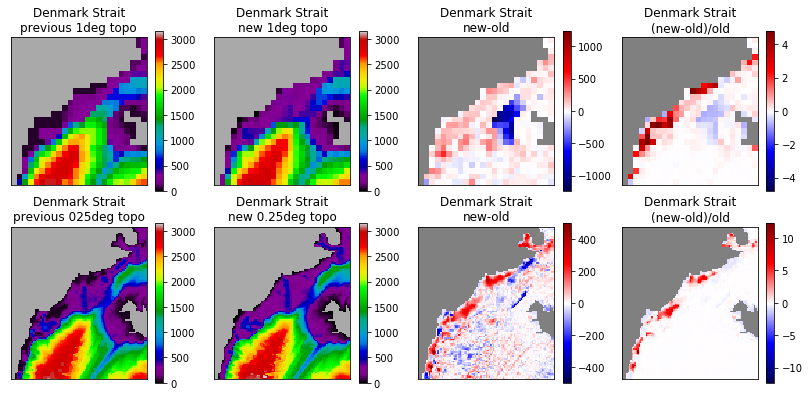

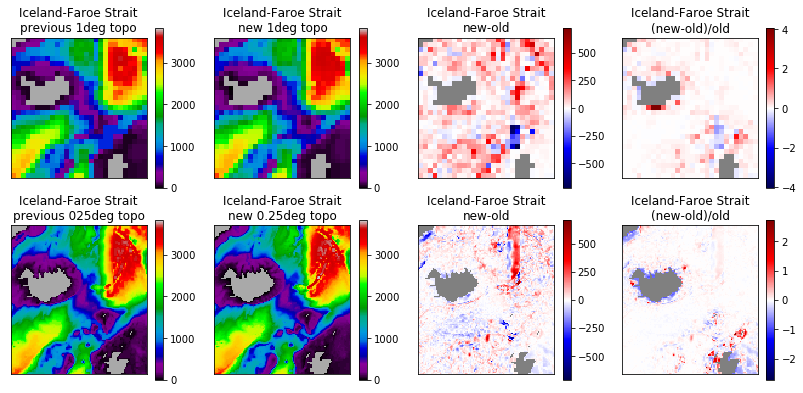

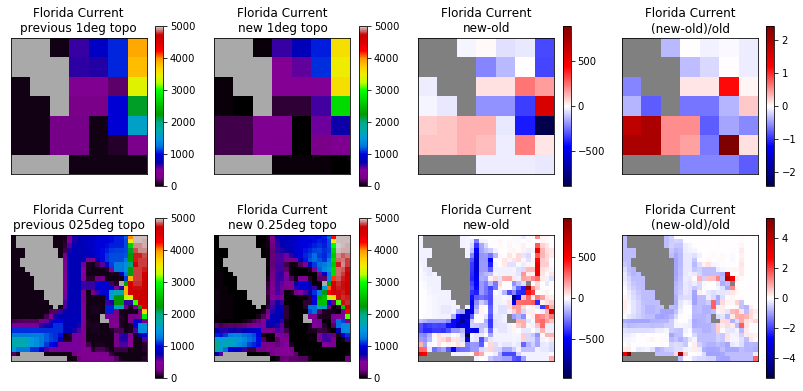

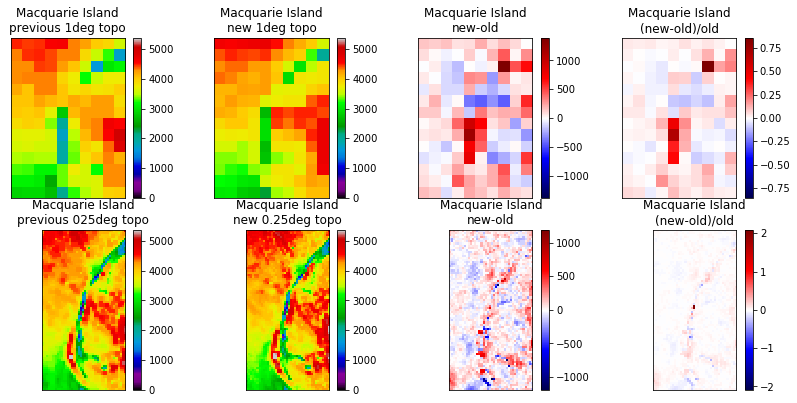

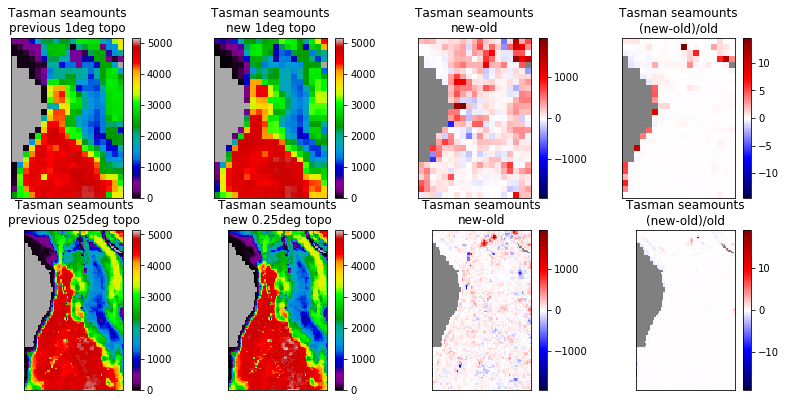

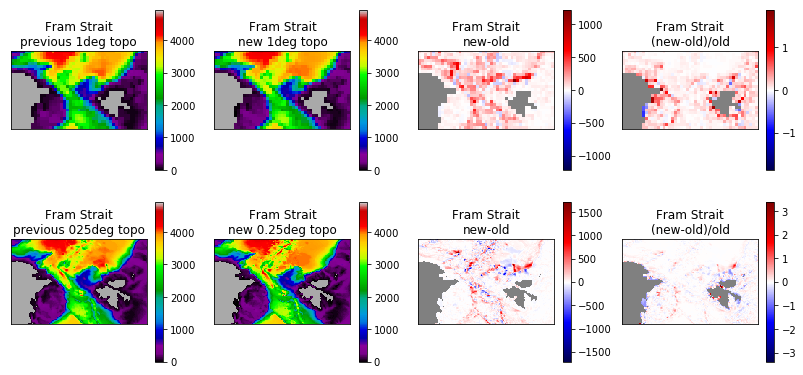

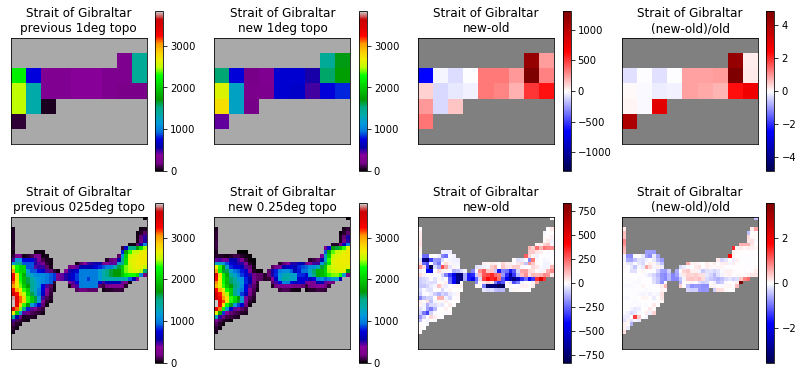

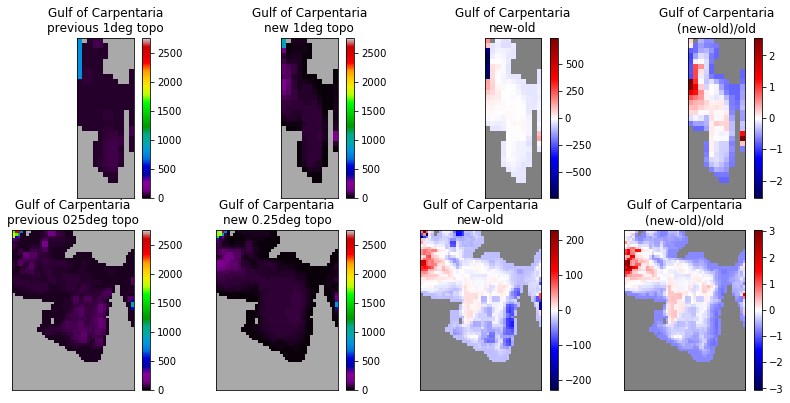

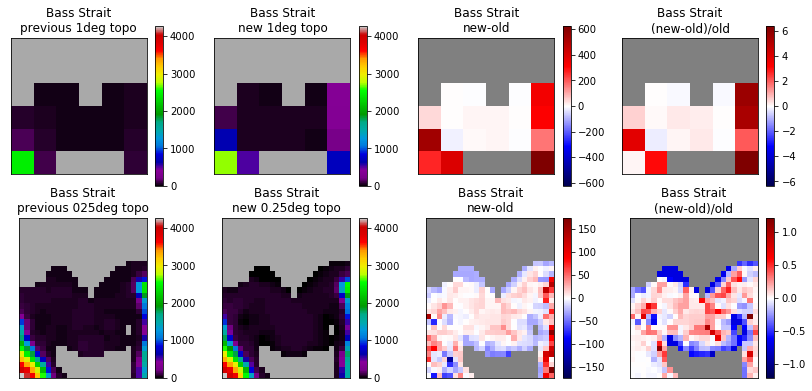

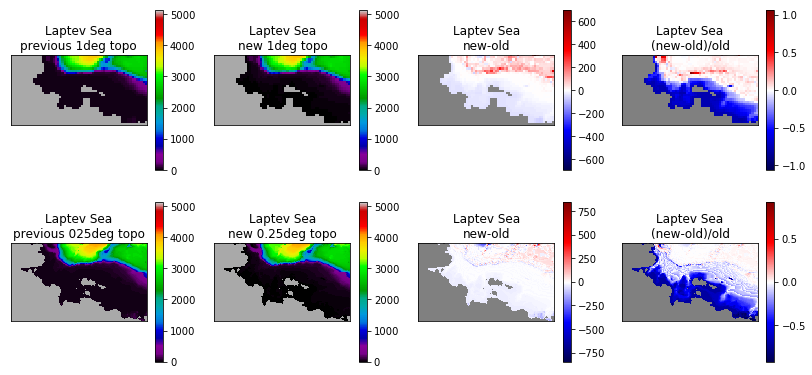

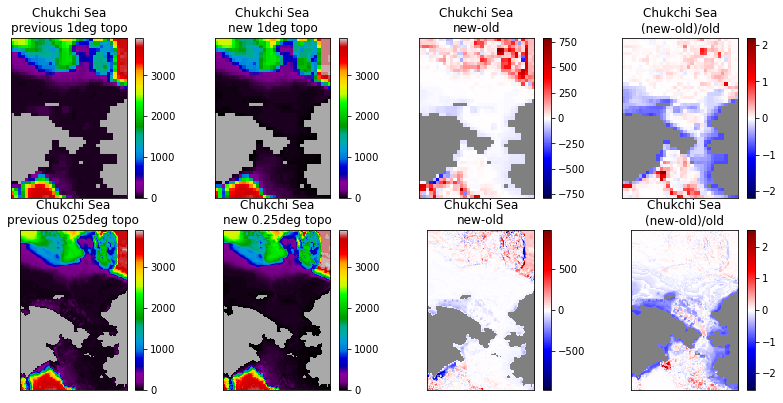

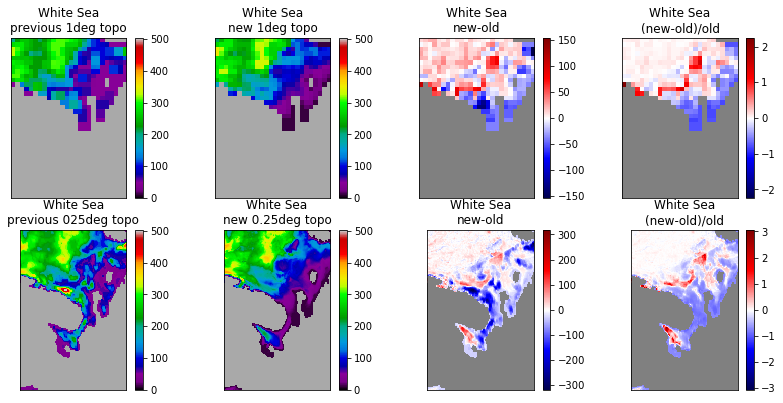

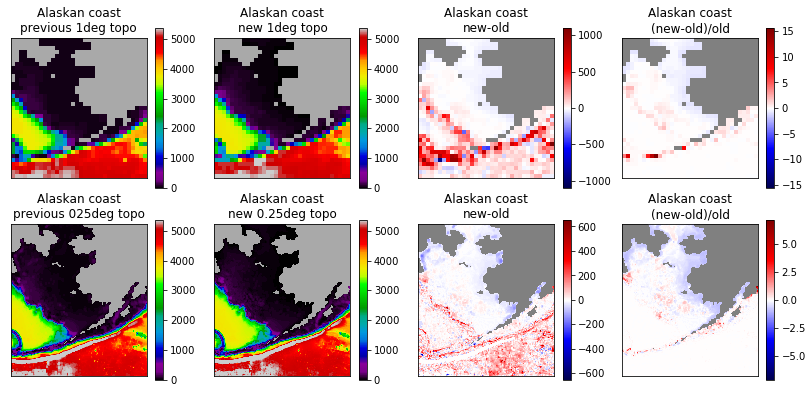

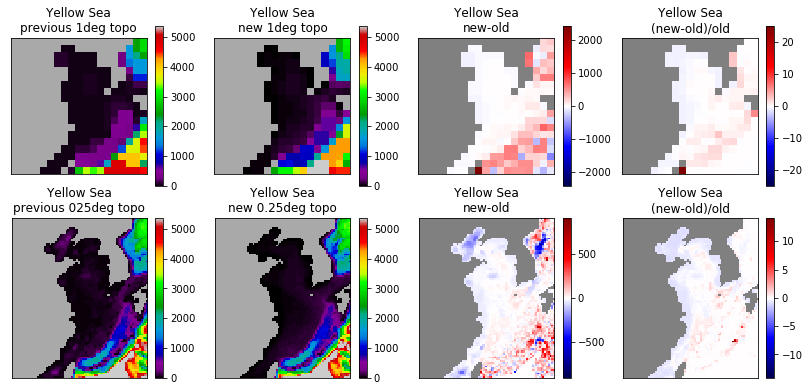

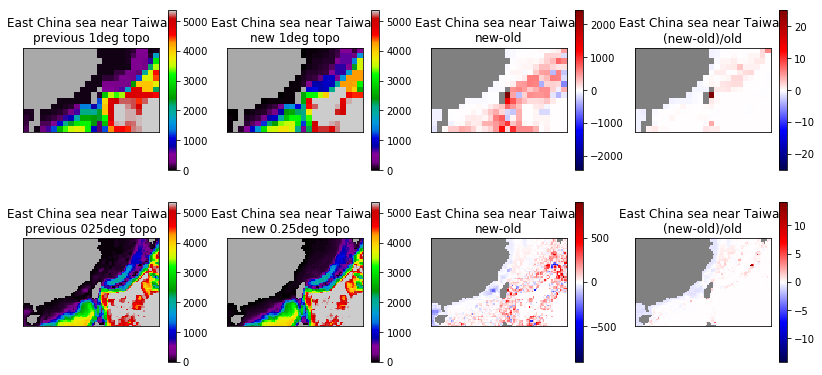

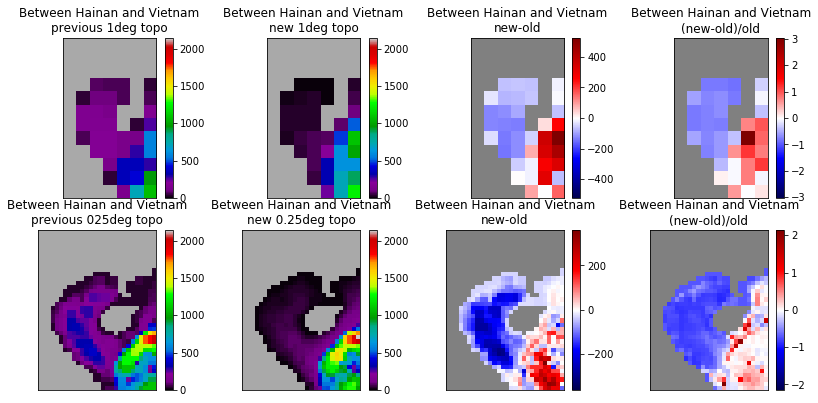

In [26]:
# plot maps of topography at feature locations
m = 2 # margin (degrees)
for feature, (xmin, xmax, ymin, ymax) in features.items():
    xmin = xmin - m
    xmax = xmax + m
    ymin = ymin - m
    ymax = ymax + m
    plt.figure(figsize=(14,10))
    dmax = 0
    dlist = list(data.items())
    for ei in range(len(data)):
        e = dlist[ei][1]
        ia, ja = nearest(e['lon'], e['lat'], xmin, ymin)
        ib, jb = nearest(e['lon'], e['lat'], xmin, ymax)
        ic, jc = nearest(e['lon'], e['lat'], xmax, ymax)
        id, jd = nearest(e['lon'], e['lat'], xmax, ymin)
        imin = min(ia, ib, ic, id)
        jmin = min(ja, jb, jc, jd)
        imax = max(ia, ib, ic, id)
        jmax = max(ja, jb, jc, jd)
        d = e['depth'].isel(nx=slice(imin, imax))\
                      .isel(ny=slice(jmin, jmax))
        d = d.where(d>0)
        dmax = max(dmax, d.max())
        plt.subplot(len(data)//2+1, 4, 1+ei+2*(ei//2))
        plt.imshow(d.data, cmap='nipy_spectral')
        current_cmap = plt.cm.get_cmap('nipy_spectral')
        current_cmap.set_bad(color='darkgray')
        plt.gca().invert_yaxis()
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
        plt.title(feature+'\n'+e['desc'])
        if ei%2 == 1:
            plt.subplot(len(data)//2+1, 4, 2+ei+2*(ei//2))
            diff = (d-prevd).data
            diffmax = np.nanmax(np.abs(diff))
            plt.imshow(diff, cmap='seismic')
            current_cmap = plt.cm.get_cmap('seismic')
            current_cmap.set_bad(color='darkgray')
            plt.gca().invert_yaxis()
            plt.xticks([])
            plt.yticks([])
            plt.colorbar()
            plt.clim([-diffmax, diffmax])
            plt.title(feature+'\nnew-old')

            plt.subplot(len(data)//2+1, 4, 3+ei+2*(ei//2))
            diff = ((d-prevd)/prevd).data
            diffmax = np.nanmax(np.abs(diff))
            plt.imshow(diff, cmap='seismic')
            current_cmap = plt.cm.get_cmap('seismic')
            current_cmap.set_bad(color='gray')
            plt.gca().invert_yaxis()
            plt.xticks([])
            plt.yticks([])
            plt.colorbar()
            plt.clim([-diffmax, diffmax])
            plt.title(feature+'\n(new-old)/old')

        prevd = d
    for ei in range(len(data)):
        plt.subplot(len(data)//2+1, 4, 1+ei+2*(ei//2))
        plt.clim([0, dmax])

## Apply previous mask - SUPERSEDED

*this has been superseded by `/scratch/v45/aek156/bathymetry/tools/1_deg_test/apply_mask.py`*

- set depth to minimum_depth wherever depth is 0 but mask is 1 
- set depth to 0 wherever mask is 0

<xarray.DataArray 'mask' (ny: 300, nx: 360)>
[108000 values with dtype=float64]
Dimensions without coordinates: ny, nx
[0. 1.]
<xarray.DataArray 'mask' (ny: 1080, nx: 1440)>
[1555200 values with dtype=float64]
Dimensions without coordinates: ny, nx
Attributes:
    standard_name:  ocean fraction at T-cell centers
    units:          none
[0. 1.]


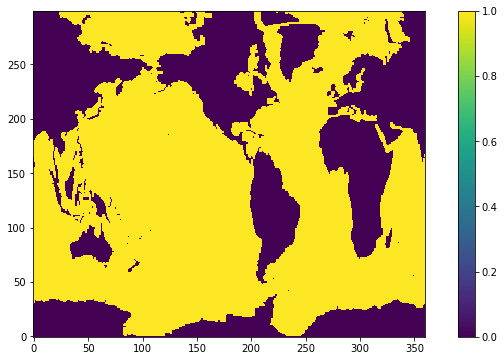

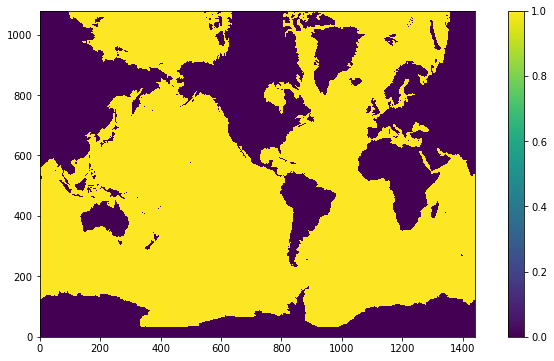

In [5]:
# load mask data
for ekey, e in data.items():
    e['mask'] = xr.open_dataset(os.path.join(e['mominput'],'ocean_mask.nc')).mask
    # mask is 0.0 on land and 1.0 in ocean (float64)
    print(e['mask'])
    plt.figure(figsize=(12,6))
    plt.imshow(e['mask'].data)
    plt.gca().invert_yaxis()
    plt.colorbar()
    print(np.unique(e['mask'].data))

<xarray.DataArray 'depth' (yy: 300, xx: 360)>
[108000 values with dtype=float32]
Dimensions without coordinates: yy, xx
Attributes:
    long_name:                   depth
    units:                       m
    minimum_depth:               11.80575
    minimum_levels:              4
    lakes_removed:               no
    nonadvective_cells_removed:  yes
<xarray.DataArray 'depth' ()>
array(0., dtype=float32)
<xarray.DataArray 'depth' ()>
array(5363.469, dtype=float32)
<xarray.DataArray 'depth' (yy: 1080, xx: 1440)>
[1555200 values with dtype=float32]
Dimensions without coordinates: yy, xx
Attributes:
    long_name:                   depth
    units:                       m
    minimum_depth:               11.80575
    minimum_levels:              4
    lakes_removed:               no
    nonadvective_cells_removed:  yes
<xarray.DataArray 'depth' ()>
array(0., dtype=float32)
<xarray.DataArray 'depth' ()>
array(5363.469, dtype=float32)


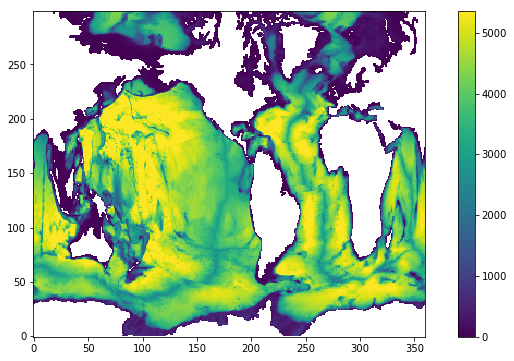

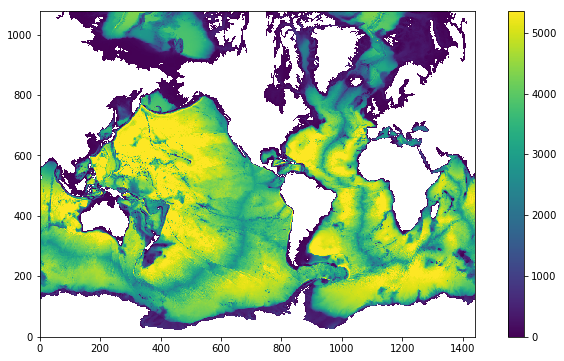

In [6]:
# load depth data
for ekey, e in data.items():
    e['depth'] = xr.open_dataset(os.path.join(e['mominput'],e['topog_file'])).depth  # partial depth
    print(e['depth'])
    print(e['depth'].min())
    print(e['depth'].max())
    plt.figure(figsize=(12,6))
    plt.imshow(e['depth'].data)
    plt.gca().invert_yaxis()
    plt.colorbar()

<xarray.DataArray 'depth' ()>
array(11.80575, dtype=float32)
<xarray.DataArray 'depth' ()>
array(11.80575)
<xarray.DataArray 'depth' ()>
array(5363.469238)
<xarray.DataArray 'depth' ()>
array(11.80575, dtype=float32)
<xarray.DataArray 'depth' ()>
array(11.80575)
<xarray.DataArray 'depth' ()>
array(5363.469238)


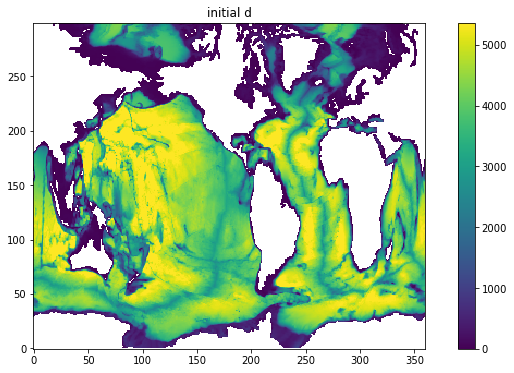

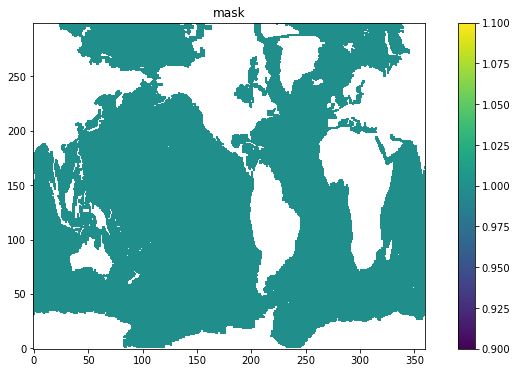

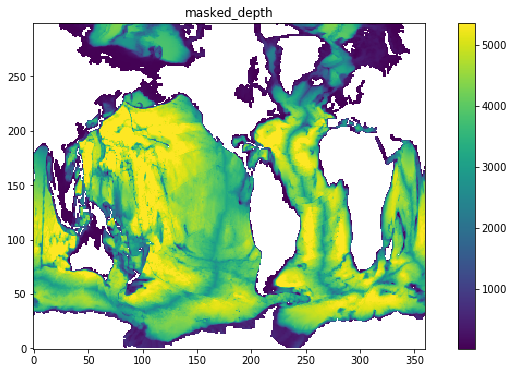

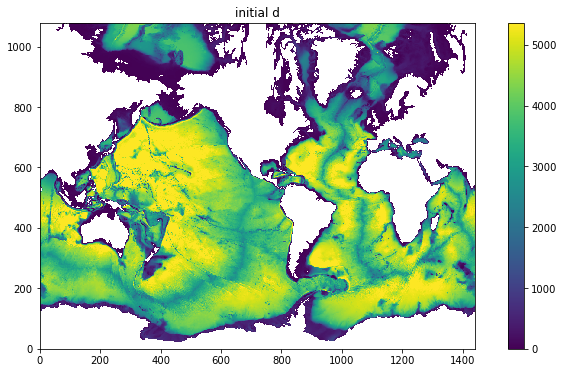

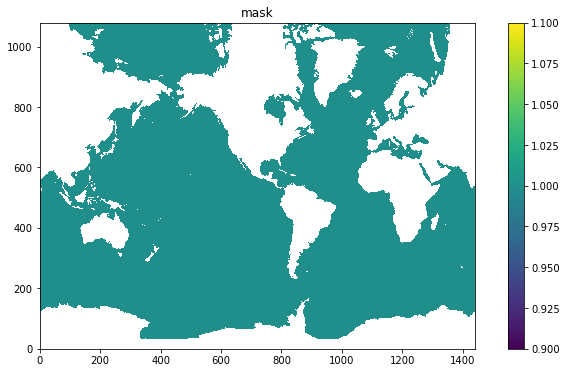

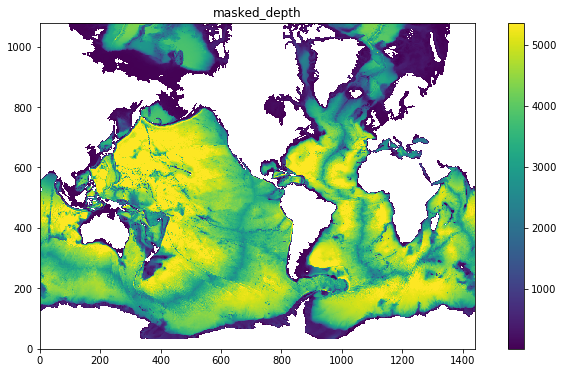

In [10]:
# apply mask to depth data
for ekey, e in data.items():
    m = e['mask']
    d = e['depth']

    plt.figure(figsize=(12,6))
    plt.imshow(d.data)
    plt.gca().invert_yaxis()
    plt.colorbar()    
    plt.title('initial d')
   
    plt.figure(figsize=(12,6))
    plt.imshow(m.where(m > 0.0).data)
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.title('mask')

    d = d.fillna(0.0)
    d = d.rename(xx='nx', yy='ny')

    minimum_depth = d.where(d>0.0).min()
    print(minimum_depth)
    
    dd = d  # to inherit all the metadata for depth
    dd.data = np.minimum(d, m*1e20).data  # dd=0 wherever m=0, otherwise dd=d
    dd.data = np.maximum(dd, m*minimum_depth).data  # masked_depth=min_depth wherever d=0 but m=1, otherwise masked_depth=dd
    e['masked_depth'] = dd.where(dd > 0.0)
    e['masked_depth'].to_netcdf(os.path.join(e['mominput'],'masked_'+e['topog_file']))
#     print(e['masked_depth'])
    print(e['masked_depth'].min())
    print(e['masked_depth'].max())
    plt.figure(figsize=(12,6))
    plt.imshow(e['masked_depth'].data)
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.title('masked_depth')

In [13]:
print(e['masked_depth'])

<xarray.DataArray 'depth' (ny: 1080, nx: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Dimensions without coordinates: ny, nx
Attributes:
    long_name:                   depth
    units:                       m
    minimum_depth:               11.80575
    minimum_levels:              4
    lakes_removed:               no
    nonadvective_cells_removed:  yes


# OLD STUFF BELOW

In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname),dpi=300, bbox_inches="tight")  # comment out to disable saving
#     plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return
fileprefix = ''

In [3]:
data = copy.deepcopy(exptdata.exptdict)  # to store fields under the same keys as exptdata.exptdict

# inputs used for final runs, copied from /short/public
data['1deg']['mominput'] = 'access-om2/input_236a3011/mom_1deg'
data['025deg']['mominput'] = 'access-om2/input_236a3011/mom_025deg'
data['01deg']['mominput'] = 'access-om2/input_38570c62/mom_01deg'

In [10]:
# add new ryf run
data['01deg_jra55v13_ryf9091_topo_bug_test'] = \
              {'model': 'access-om2-01',
               'expt': '01deg_jra55v13_ryf9091_topo_bug_test/',
               'desc': 'ACCESS-OM2-01 RYF 1990-91 topo bug test',
               'n_files': None,
#                'time_units': 'days since 0001-01-01',
               'time_units': 'days since 1988-01-01', # so .sel(time=slice(pd.datetime(1998,1,1),None)) removes first 10 years
               'offset': None,
               'exptdir': '/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_ryf9091_topo_bug_test/',
               'mominput': 'access-om2/input_08022019/mom_01deg'}
fileprefix = 'new_'

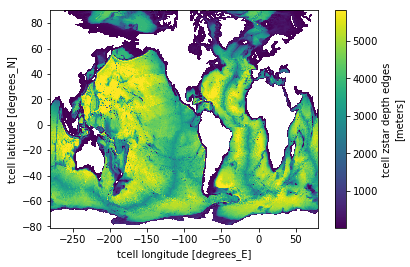

In [7]:
e['depth_full'].plot()

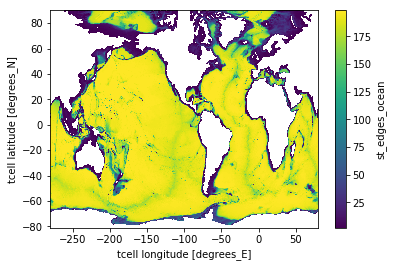

In [8]:
e['dz_full'].plot()

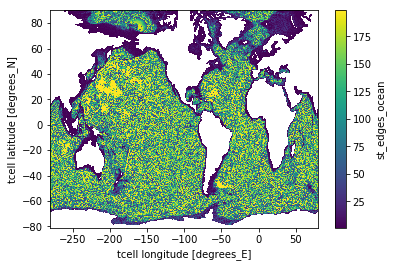

In [9]:
e['dz'].plot()

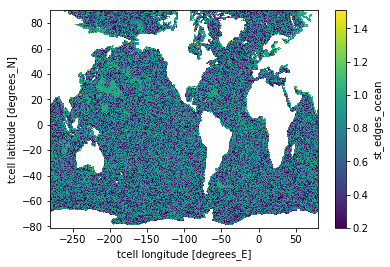

In [10]:
ratio.plot()

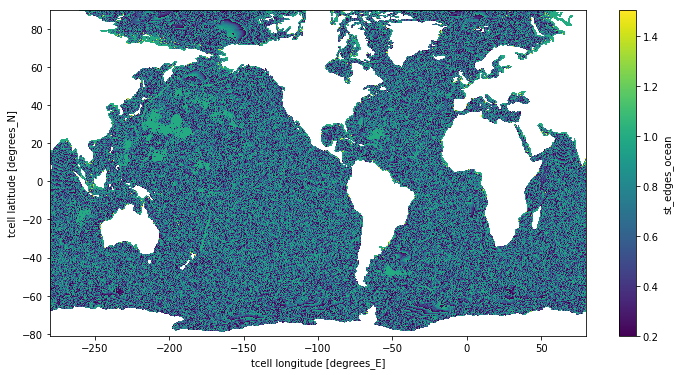

In [23]:
ratio.where(ratio>-1).plot(figsize=(12,6))

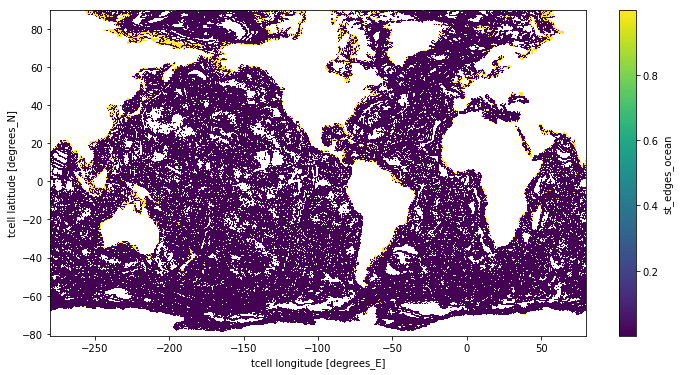

In [22]:
thickdiff = e['dz']-e['dz_full']
thickdiff.where(thickdiff>=0).plot(figsize=(12,6))

In [12]:
# depth below which there is some degree of partial cell
data['01deg']['st_edges_ocean'][1:].where(e['st_edges_ocean'].diff('st_edges_ocean')>10)

<xarray.DataArray 'st_edges_ocean' (st_edges_ocean: 75)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,  103.020921,  114.916569,
        128.057163,  142.571677,  158.601991,  176.304021,  195.848899,
        217.424171,  241.234991,  267.505267,  296.478698,  328.419629,
        363.613608,  402.367523,  445.009148,  491.885883,  543.362463,
        599.817368,  661.637658,  729.211985,  802.921614,  883.129412,
        970.166985, 1064.32043 , 1165.81552 , 1274.803471, 1391.348715,
       1515.420165, 1646.88731 , 1785.521992, 1931.006066, 2082.94433 ,
       2240.881435, 2404.321033, 2572.745269, 2745.632958, 2922.475179,
       3102.787584, 3286.119189, 3472.057852, 3660.232873, 3850.315322,
       

In [13]:
# depth below which 20% threshold is actual lower limit
data['01deg']['st_edges_ocean'][1:].where(e['st_edges_ocean'].diff('st_edges_ocean')>50)

<xarray.DataArray 'st_edges_ocean' (st_edges_ocean: 75)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,  543.362463,
        599.817368,  661.637658,  729.211985,  802.921614,  883.129412,
        970.166985, 1064.32043 , 1165.81552 , 1274.803471, 1391.348715,
       1515.420165, 1646.88731 , 1785.521992, 1931.006066, 2082.94433 ,
       2240.881435, 2404.321033, 2572.745269, 2745.632958, 2922.475179,
       3102.787584, 3286.119189, 3472.057852, 3660.232873, 3850.315322,
       

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


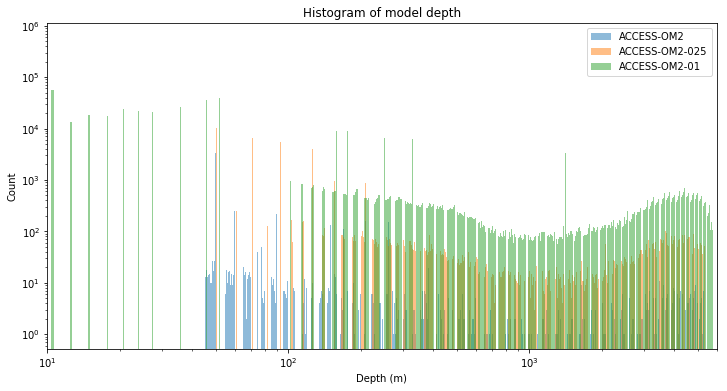

In [9]:
plt.figure(figsize=(12,6))
for ekey in data.keys():
    e = data[ekey]
    plt.hist(np.ma.ravel(e['depth']), bins=20000, alpha=0.5, log=True, label=e['desc'])
plt.xlim(10,6000)
plt.xscale('log')
plt.xlabel('Depth (m)')
plt.ylabel('Count');
plt.title('Histogram of model depth');
plt.legend(loc='upper right')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >

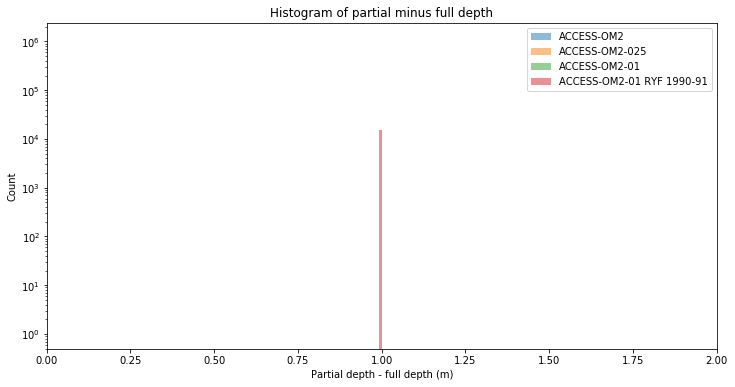

In [20]:
plt.figure(figsize=(12,6))
for ekey in data.keys():
    e = data[ekey]
    plt.hist(np.ma.ravel(e['dz']-e['dz_full']), bins=20000, alpha=0.5, log=True, label=e['desc'])
plt.xlim(0.001,2)
plt.xlabel('Partial depth - full depth (m)')
plt.ylabel('Count');
plt.title('Histogram of partial minus full depth');
plt.legend(loc='upper right')

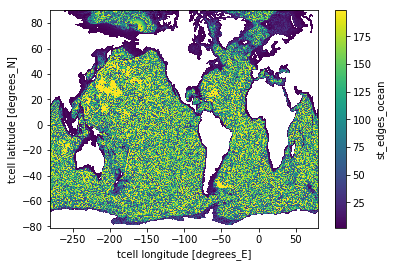

In [10]:
e['dz'].plot()

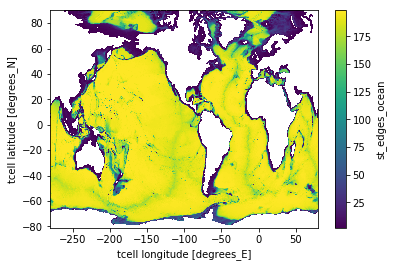

In [11]:
e['dz_full'].plot()

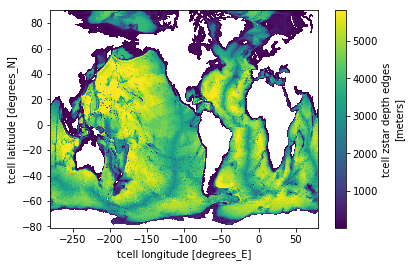

In [12]:
e['depth_full'].plot()

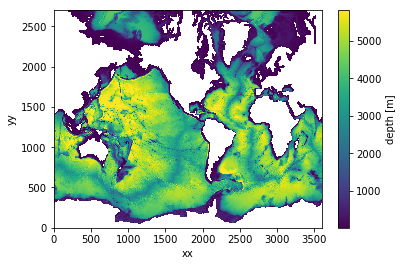

In [13]:
e['depth'].plot()